In [127]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import rice
from scipy.special import iv as Iv
from scipy.stats.mstats import gmean

import emcee
from multiprocessing import Pool

import time
import corner

from getdist import plots, MCSamples
import getdist

# import pymc3 as pm
# import arviz as az

# import dynesty

# import theano
# import theano.tensor as tt

# from theano.compile.ops import as_op

%config InlineBackend.figure_format = 'png'
%config Completer.use_jedi = False
%matplotlib inline

In [233]:
import Loglikeli
import copy 
import importlib
import utilities
importlib.reload(utilities)
from utilities import Mask, Bp2f

In [3]:
fres = np.array([2.3, 5, 23, 28, 33]); nu0 = gmean(fres); nside = 32

In [7]:
total_P = np.load('/global/cscratch1/sd/jianyao/CBASS/Observations/homo_noise/totalP_s0_%s_uK_RJ_000.npy'%nside)#/1000 ## from uK to mK
total_sigma = np.load('/global/cscratch1/sd/jianyao/CBASS/Noise/homo_noise/5_fre_sigma_P_%s_uK_RJ.npy'%nside)#/1000 ## from uK to mK
P_nu0 = np.load('/global/cscratch1/sd/jianyao/CBASS/Foreground/P_11.99_s0_32_uK_RJ.npy')#/1000

mask_both = np.load('/global/cscratch1/sd/jianyao/CBASS/mask_both_%s.npy'%nside)
mask_index = np.load('/global/cscratch1/sd/jianyao/CBASS/masked_index.npy')

In [80]:
P_nu0[5829]

873.5174

In [150]:
P_nu0[5957]

1862.014

In [178]:
P_nu0[5958]

772.1207

In [177]:
P_nu0[4296]

829.2788

In [194]:
frelist = [0,2,3,4]; index = 4296#744#5829

logL = Loglikeli.logLike(nside, fres,frelist, total_P, total_sigma, index)

In [217]:
npara = 2; 

def log_prior(theta):
    A0, beta = theta; 
    if 0 < A0 < 2000 and -4 < beta < -2:
        return 0.0
    return -np.inf

def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logL.loglike(theta)

pos = np.array((100, -4)) + 1e-4 * np.random.randn(64, 2)

nwalkers, ndim = pos.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool)
    start = time.time()
    sampler.run_mcmc(pos, 1000, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    

# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
# start = time.time()
# sampler.run_mcmc(pos, 500, progress=True)
# end = time.time()
# multi_time = end - start
# print("Multiprocessing took {0:.1f} seconds".format(multi_time))

  0%|          | 0/1000 [00:00<?, ?it/s]/global/homes/j/jianyao/my3.8/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:11<00:00, 90.11it/s]


Multiprocessing took 11.1 seconds


In [218]:
A0, beta = np.median(sampler.flatchain, axis = 0)
print(np.median(sampler.flatchain[:,0]))
print(np.median(sampler.flatchain[:,1]))

408.27162096476707
-3.0415825724692196


In [219]:
mcmc = np.percentile(sampler.flatchain[:,1], [16, 50, 84])

In [220]:
mcmc

array([-3.65341679, -3.04158257, -3.00742723])

In [221]:
np.diff(mcmc)

array([0.61183422, 0.03415534])

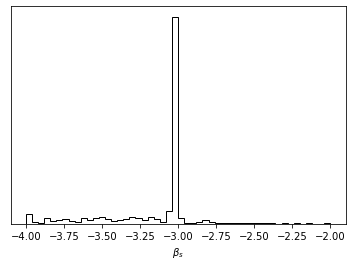

In [215]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 1], 50, color="k", histtype="step")
plt.xlabel(r"$\beta_s$")
# plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

In [148]:
# tau = sampler.get_autocorr_time()
# print(tau)

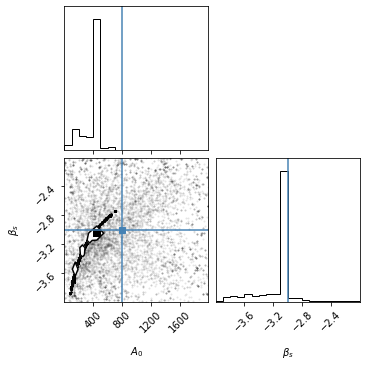

In [216]:
flat_samples = sampler.get_chain(discard=100, thin=1, flat=True)

labels = ['$A_0$', r'$\beta_s$']
fig = corner.corner(
    flat_samples, labels=labels, truths=[800,-3]
);

# adaptive prior of A

In [164]:
npara = 2; 

def log_prior(theta, A_ref):
    A0, beta = theta; 
    if A_ref - 1862 < A0 < A_ref + 200 and -4 < beta < -2:
        return 0.0
    return -np.inf

def log_probability(theta, A_ref):
    lp = log_prior(theta, A_ref)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logL.loglike(theta)

pos = np.array((100, -4)) + 1e-4 * np.random.randn(64, 2)
nwalkers, ndim = pos.shape

# with Pool() as pool:
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool, args=(P_nu0[5957],))
#     start = time.time()
#     sampler.run_mcmc(pos, 500, progress=True)
#     end = time.time()
#     multi_time = end - start
#     print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(P_nu0[index],))
start = time.time()
sampler.run_mcmc(pos, 500, progress=True)
end = time.time()
multi_time = end - start
print("Multiprocessing took {0:.1f} seconds".format(multi_time))

A0, beta = np.median(sampler.flatchain, axis = 0)
print(np.median(sampler.flatchain[:,0]))
print(np.median(sampler.flatchain[:,1]))

100%|██████████| 500/500 [00:15<00:00, 31.28it/s]

Multiprocessing took 16.0 seconds


In [15]:
flat_samples.shape

(832, 2)

In [92]:
names = ['1', '2']
labels = ['A_0', 'beta_s']
samples = MCSamples(samples=flat_samples,names = names, labels = labels)
# samples2 = MCSamples(samples=flat_samples[:,1],names = names, labels = labels, label='Second set')

Removed no burn in


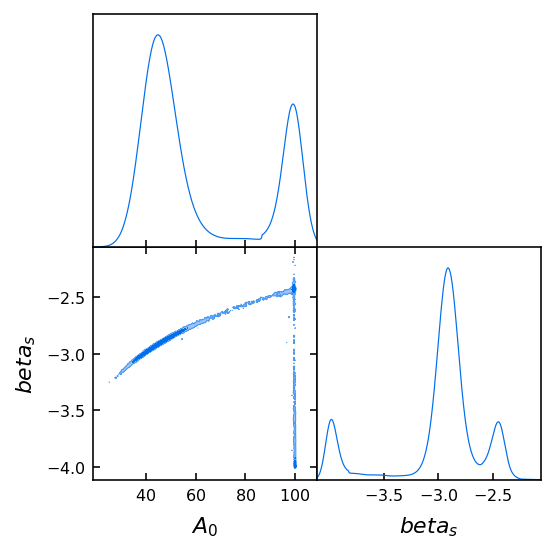

In [93]:
g = plots.get_subplot_plotter()
g.triangle_plot([samples], filled=True)

# Results

## SNR

In [224]:
sn_both = gmean(total_P/total_sigma, axis = 0)
sn_C = gmean((total_P/total_sigma)[1:5], axis = 0)
sn_S = gmean([(total_P/total_sigma)[0],(total_P/total_sigma)[2],(total_P/total_sigma)[3],(total_P/total_sigma)[4]])

## Likelihood

In [222]:
As_betas_both = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Emcee_As_betas_masked_both_32_with_SPASS_CBASS_v4.npy')
As_betas_S = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Emcee_As_betas_masked_both_32_with_SPASS_only_v4.npy')
As_betas_C = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Emcee_As_betas_masked_both_32_with_CBASS_only_v4.npy')

In [235]:
betas_both = Bp2f(As_betas_both, mask_index, nside = nside)[1]
betas_C = Bp2f(As_betas_C, mask_index, nside = nside)[1]
betas_S = Bp2f(As_betas_S, mask_index, nside = nside)[1]

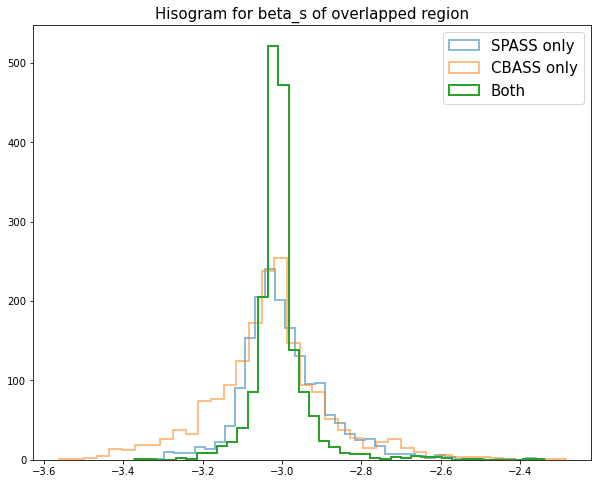

In [223]:
plt.figure(figsize = (10,8))
plt.hist(As_betas_S[1],  bins = 40, histtype="step", label = 'SPASS only', lw = 2, alpha = 0.5)

plt.hist(As_betas_C[1], bins = 40, histtype="step" , label = 'CBASS only', lw = 2, alpha = 0.5)

plt.hist(As_betas_both[1],  bins = 40, histtype="step" , label = 'Both', lw = 2)

plt.title('Hisogram for beta_s of overlapped region', fontsize = 15)
plt.legend(fontsize = 15)

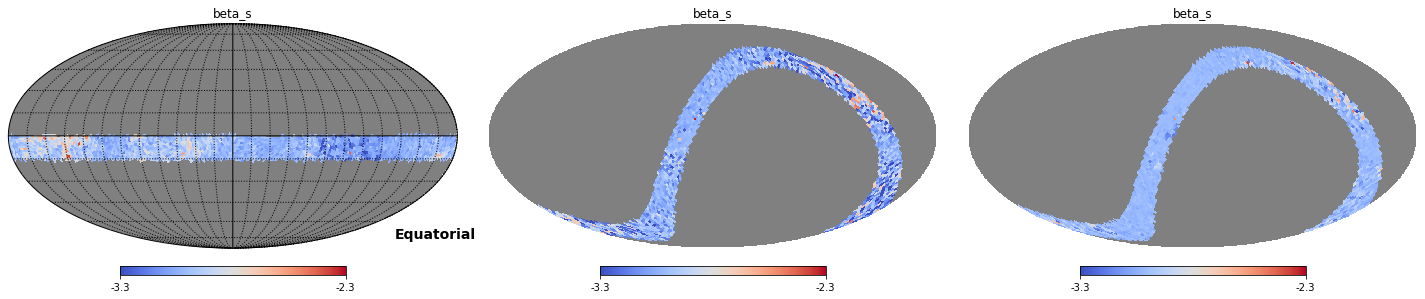

In [237]:
plt.figure(figsize = (20, 10))
hp.mollview(betas_S, cmap = 'coolwarm', sub = 231, title = 'beta_s', min = -3.3, max = -2.3, coord=['G','C'])
hp.graticule(15)
hp.mollview(betas_C, cmap = 'coolwarm', sub = 232, title = 'beta_s', min = -3.3, max = -2.3)
hp.mollview(betas_both, cmap = 'coolwarm',sub = 233, title = 'beta_s', min = -3.3, max = -2.3)


# hp.mollview(Mask(Sn_S, mask_both), norm = 'hist', cmap = 'coolwarm',sub = 234, title = 'SNR')
# hp.mollview(Mask(Sn_C, mask_both), norm = 'hist', cmap = 'coolwarm', sub = 235, title = 'SNR')
# hp.mollview(Mask(Sn_both,mask_both), norm = 'hist', cmap = 'coolwarm', sub = 236, title = 'SNR')

## 2d hist

Text(0.5, 0, '$log_{10}(S/N)$, Geometric mean')

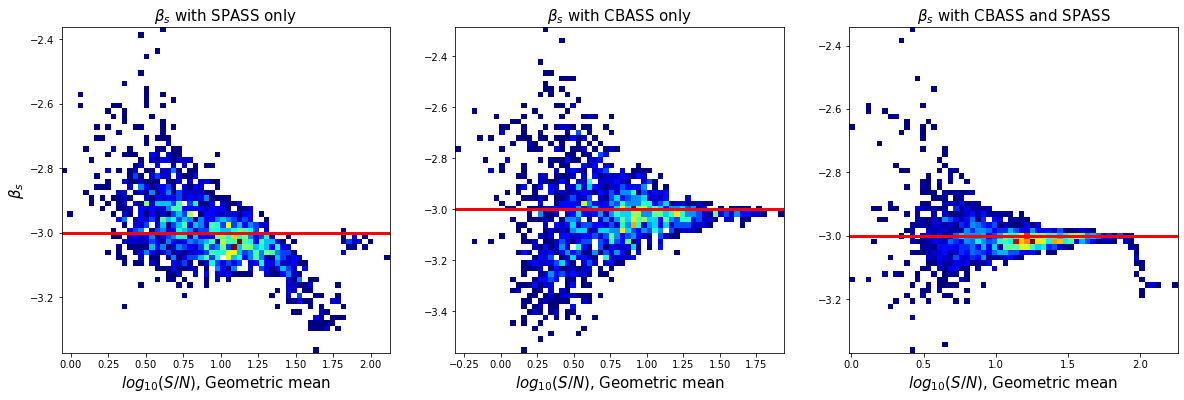

In [236]:
fig, ax = plt.subplots(1,3, figsize = (20,6))
my_cmap = copy.copy(plt.cm.get_cmap("jet"))
my_cmap.set_under('w',0)

x0, y0 = sn_S[mask_index], betas_S[mask_index]
ax[0].hist2d(np.log10(x0),y0, bins = 60, cmap = my_cmap, cmin = 1) #cmap = plt.cm.GnBu
ax[0].set_title(r'$\beta_s$ with SPASS only', fontsize = 15)
ax[0].axhline(-3.0, c = 'red', lw = 3)
ax[0].set_ylabel(r'$\beta_s$', fontsize = 15)
ax[0].set_xlabel(r'$log_{10}(S/N)$, Geometric mean', fontsize = 15)

x0, y0 = sn_C[mask_index], betas_C[mask_index]
ax[1].hist2d(np.log10(x0),y0, bins = 60, cmap = my_cmap, cmin = 1) #cmap = plt.cm.GnBu
ax[1].set_title(r'$\beta_s$ with CBASS only', fontsize = 15)
ax[1].axhline(-3.0, c = 'red', lw = 3)
ax[1].set_xlabel(r'$log_{10}(S/N)$, Geometric mean', fontsize = 15)

x0, y0 = sn_both[mask_index], betas_both[mask_index]
ax[2].hist2d(np.log10(x0),y0, bins = 60, cmap = my_cmap, cmin = 1) #cmap = plt.cm.GnBu
ax[2].set_title(r'$\beta_s$ with CBASS and SPASS', fontsize = 15)
ax[2].axhline(-3.0, c = 'red', lw = 3)
ax[2].set_xlabel(r'$log_{10}(S/N)$, Geometric mean', fontsize = 15)
# fig.colorbar(h)

## combine with high SNR region

In [238]:
H_As_betas_S = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Emcee_As_betas_masked_both_32_with_SPASS_only_v6.npy')
H_As_betas_C = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Emcee_As_betas_masked_both_32_with_CBASS_only_v6.npy')
H_As_betas_both = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Emcee_As_betas_masked_both_32_with_SPASS_CBASS_v6.npy')

In [239]:
orders = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/High_SNR_pixels_300.npy')

In [240]:
All_betas_S = np.copy(betas_S)
All_betas_C = np.copy(betas_C)
All_betas_both = np.copy(betas_both)

All_betas_S[orders] = H_As_betas_S[1]
All_betas_C[orders] = H_As_betas_C[1]
All_betas_both[orders] = H_As_betas_both[1]

Text(0.5, 0, '$log_{10}(S/N)$, Geometric mean')

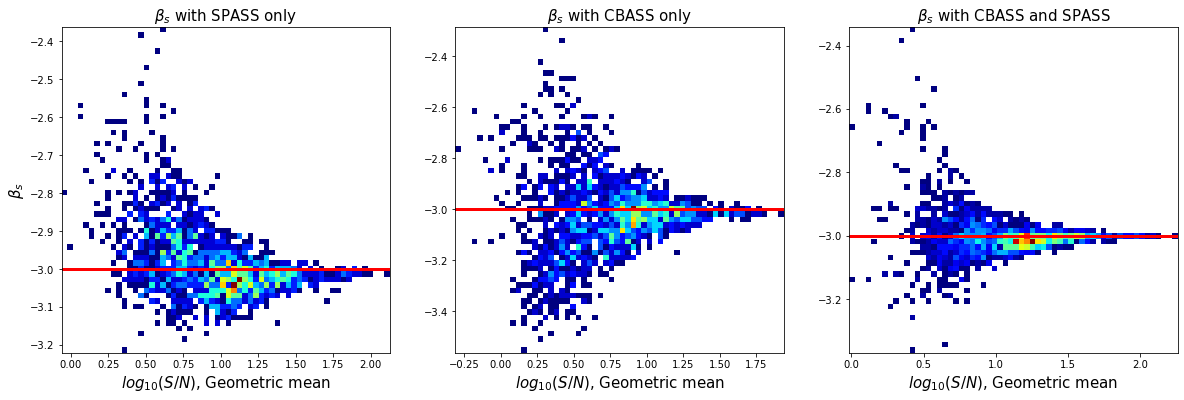

In [241]:
fig, ax = plt.subplots(1,3, figsize = (20,6))
my_cmap = copy.copy(plt.cm.get_cmap("jet"))
my_cmap.set_under('w',0)

x0, y0 = sn_S[mask_index], All_betas_S[mask_index]
ax[0].hist2d(np.log10(x0),y0, bins = 60, cmap = my_cmap, cmin = 1) #cmap = plt.cm.GnBu
ax[0].set_title(r'$\beta_s$ with SPASS only', fontsize = 15)
ax[0].axhline(-3.0, c = 'red', lw = 3)
ax[0].set_ylabel(r'$\beta_s$', fontsize = 15)
ax[0].set_xlabel(r'$log_{10}(S/N)$, Geometric mean', fontsize = 15)

x0, y0 = sn_C[mask_index], All_betas_C[mask_index]
ax[1].hist2d(np.log10(x0),y0, bins = 60, cmap = my_cmap, cmin = 1) #cmap = plt.cm.GnBu
ax[1].set_title(r'$\beta_s$ with CBASS only', fontsize = 15)
ax[1].axhline(-3.0, c = 'red', lw = 3)
ax[1].set_xlabel(r'$log_{10}(S/N)$, Geometric mean', fontsize = 15)

x0, y0 = sn_both[mask_index], All_betas_both[mask_index]
ax[2].hist2d(np.log10(x0),y0, bins = 60, cmap = my_cmap, cmin = 1) #cmap = plt.cm.GnBu
ax[2].set_title(r'$\beta_s$ with CBASS and SPASS', fontsize = 15)
ax[2].axhline(-3.0, c = 'red', lw = 3)
ax[2].set_xlabel(r'$log_{10}(S/N)$, Geometric mean', fontsize = 15)
# fig.colorbar(h)

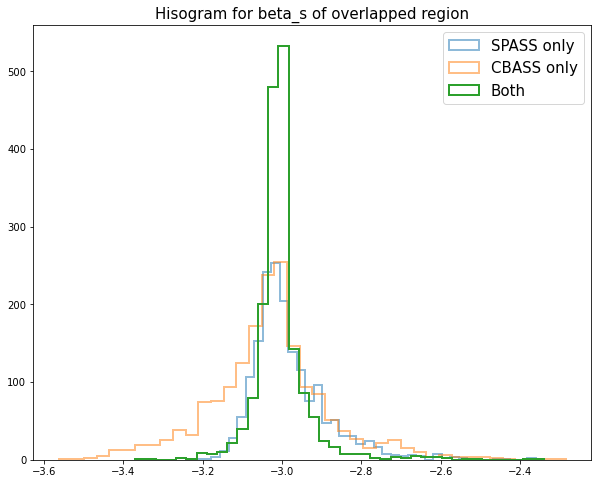

In [242]:
plt.figure(figsize = (10,8))
plt.hist(All_betas_S[mask_index],  bins = 40, histtype="step", label = 'SPASS only', lw = 2, alpha = 0.5)

plt.hist(As_betas_C[1], bins = 40, histtype="step" , label = 'CBASS only', lw = 2, alpha = 0.5)

plt.hist(All_betas_both[mask_index],  bins = 40, histtype="step" , label = 'Both', lw = 2)

plt.title('Hisogram for beta_s of overlapped region', fontsize = 15)
plt.legend(fontsize = 15)